# Building Model For Predicting Bike Availability

# Loading data and merging into one data frame

In [10]:
import pandas as pd
import numpy as np

availability = pd.read_csv("static/csv/availability.csv")
weather = pd.read_csv("static/csv/current_weather.csv")

df = availability.merge(weather[["weather_desc", "temp", "wind_speed", "wind_deg", "timestamp"]], on = ["timestamp"], how = "left")
df.head()

number  available_bikes  available_bike_stands status    last_update  \
0      42               30                      0   OPEN  1677185535000   
1      30                4                     16   OPEN  1677185621000   
2      54                5                     28   OPEN  1677185522000   
3     108               13                     22   OPEN  1677185161000   
4      20                6                     24   OPEN  1677185529000   

    timestamp weather_desc  temp  wind_speed  wind_deg  
0  1677185702          NaN   NaN         NaN       NaN  
1  1677185702          NaN   NaN         NaN       NaN  
2  1677185702          NaN   NaN         NaN       NaN  
3  1677185702          NaN   NaN         NaN       NaN  
4  1677185702          NaN   NaN         NaN       NaN

# Cleaning data frame

## Columns - dropping and renaming

In [11]:
df.drop(["status", "last_update", "available_bike_stands"], axis = 1, inplace = True)
df.head()

number  available_bikes   timestamp weather_desc  temp  wind_speed  \
0      42               30  1677185702          NaN   NaN         NaN   
1      30                4  1677185702          NaN   NaN         NaN   
2      54                5  1677185702          NaN   NaN         NaN   
3     108               13  1677185702          NaN   NaN         NaN   
4      20                6  1677185702          NaN   NaN         NaN   

   wind_deg  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

## Rows - dropping rows with no weather data

In [12]:
df.dropna(inplace = True)
df.head()

number  available_bikes   timestamp weather_desc    temp  wind_speed  \
336580      42               16  1678113903   light rain  278.81        3.09   
336581      30                0  1678113903   light rain  278.81        3.09   
336582      54               17  1678113903   light rain  278.81        3.09   
336583     108               14  1678113903   light rain  278.81        3.09   
336584      20               22  1678113903   light rain  278.81        3.09   

        wind_deg  
336580     290.0  
336581     290.0  
336582     290.0  
336583     290.0  
336584     290.0

## Date and Time - changing Unix timestamp

In [13]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit = "s")
df["month"] = df['timestamp'].dt.month  # 1-12
df["day"] = df['timestamp'].dt.dayofweek  # 0-6
df["hour"] = df['timestamp'].dt.hour  # 0-23

df.drop("timestamp", axis = 1, inplace = True)
df.head()

number  available_bikes weather_desc    temp  wind_speed  wind_deg  \
336580      42               16   light rain  278.81        3.09     290.0   
336581      30                0   light rain  278.81        3.09     290.0   
336582      54               17   light rain  278.81        3.09     290.0   
336583     108               14   light rain  278.81        3.09     290.0   
336584      20               22   light rain  278.81        3.09     290.0   

        month  day  hour  
336580      3    0    14  
336581      3    0    14  
336582      3    0    14  
336583      3    0    14  
336584      3    0    14

## Reindexing columns

In [14]:
column_order = ["number", "month", "day", "hour", "temp", "weather_desc", "wind_speed", "wind_deg", "available_bikes"]
df = df.reindex(columns = column_order)
df.head()

number  month  day  hour    temp weather_desc  wind_speed  wind_deg  \
336580      42      3    0    14  278.81   light rain        3.09     290.0   
336581      30      3    0    14  278.81   light rain        3.09     290.0   
336582      54      3    0    14  278.81   light rain        3.09     290.0   
336583     108      3    0    14  278.81   light rain        3.09     290.0   
336584      20      3    0    14  278.81   light rain        3.09     290.0   

        available_bikes  
336580               16  
336581                0  
336582               17  
336583               14  
336584               22

## Replacing weather_desc values with corresponding weather IDs

When I started scraping the weather data, I never included the weather IDs for each call to the OpenWeather APIs, preferring to pull a description of the weather in English. It has occured to me that it would have been far more useful to scrape the weather IDs for the purposes of training the model. So, I have counted each unique value for weather descriptions from our database, and below I will replace all of the weather description strings in the weather_desc feature of the data frame with their corresponding weather IDs, as described here: https://openweathermap.org/weather-conditions

In [15]:
df["weather_desc"] = df["weather_desc"].replace({"light rain": 500, "broken clouds": 803, "moderate rain": 501, "light intensity drizzle": 300, "clear sky": 800, "overcast clouds": 804, 
                                                 "scattered clouds": 802, "few clouds": 801, "snow": 601, "heavy intensity rain": 502, "sleet": 611, "mist": 701, "light snow": 600, 
                                                 "light intensity shower rain": 520, "light intensity drizzle rain": 310, "shower rain": 521, "fog": 741})
df.head()

number  month  day  hour    temp  weather_desc  wind_speed  wind_deg  \
336580      42      3    0    14  278.81           500        3.09     290.0   
336581      30      3    0    14  278.81           500        3.09     290.0   
336582      54      3    0    14  278.81           500        3.09     290.0   
336583     108      3    0    14  278.81           500        3.09     290.0   
336584      20      3    0    14  278.81           500        3.09     290.0   

        available_bikes  
336580               16  
336581                0  
336582               17  
336583               14  
336584               22

## Grouping by station number

In [16]:
stations = df.groupby("number")
print(stations.get_group(1))

         number  month  day  hour    temp  weather_desc  wind_speed  wind_deg  \
336596        1      3    0    14  278.81           500        3.09     290.0   
336711        1      3    0    14  278.56           500        3.09     290.0   
336826        1      3    0    14  278.56           500        3.09     290.0   
336941        1      3    0    15  278.45           500        3.09     290.0   
337056        1      3    0    15  278.30           500        3.09     290.0   
...         ...    ...  ...   ...     ...           ...         ...       ...   
1281012       1      4    1     8  281.88           500        3.09     200.0   
1281126       1      4    1     8  281.88           500        3.09     200.0   
1281240       1      4    1     8  282.24           803        3.09     200.0   
1281354       1      4    1     8  282.24           803        3.09     200.0   
1281468       1      4    1     8  282.00           803        3.09     160.0   

         available_bikes  


# Model building

In [17]:
from sklearn.ensemble import RandomForestRegressor

models = {}

for station_num, station_df in stations:
    x = station_df.drop("available_bikes", axis = 1)
    y = station_df["available_bikes"]
    model = RandomForestRegressor(max_depth=5, random_state=100)
    model.fit(x, y)
    models[station_num] = model
    print(f"Group {station_num}: Feature importances={model.feature_importances_}")


Group 1: Feature importances=[0.         0.00162655 0.35287083 0.42345128 0.14125045 0.00083937
 0.02663765 0.05332386]
Group 2: Feature importances=[0.         0.00383033 0.17179061 0.33740085 0.17956469 0.11245478
 0.16171814 0.0332406 ]
Group 3: Feature importances=[0.         0.0034559  0.24310796 0.16470437 0.20045169 0.04604606
 0.10246919 0.23976482]
Group 4: Feature importances=[0.         0.03689648 0.20706926 0.28222928 0.19046903 0.02552114
 0.09449314 0.16332167]
Group 5: Feature importances=[0.         0.01640886 0.36663467 0.49129469 0.07196562 0.00072487
 0.01360558 0.03936572]
Group 6: Feature importances=[0.         0.01436849 0.53557536 0.15590835 0.08716676 0.00481982
 0.06609922 0.13606199]
Group 7: Feature importances=[0.         0.00791183 0.4008696  0.12725131 0.16838874 0.08728563
 0.07170986 0.13658303]
Group 8: Feature importances=[0.         0.02450713 0.24876924 0.13511051 0.28340214 0.0099138
 0.14097119 0.15732599]
Group 9: Feature importances=[0.         

## Applying model to make a prediction

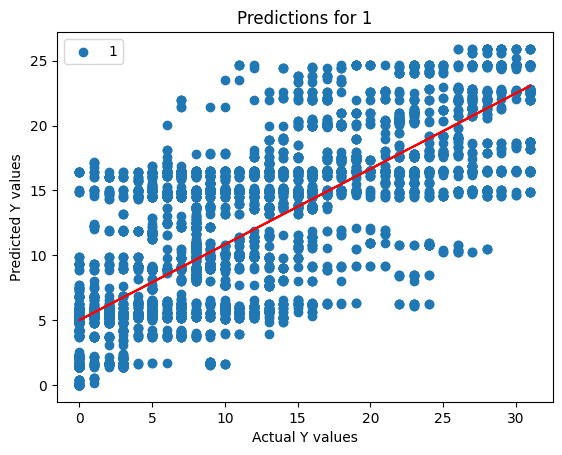

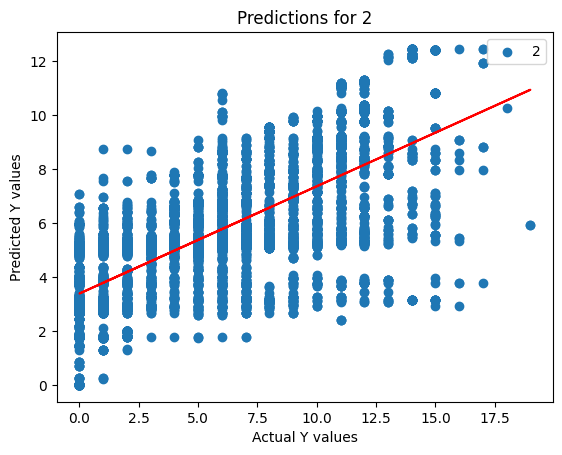

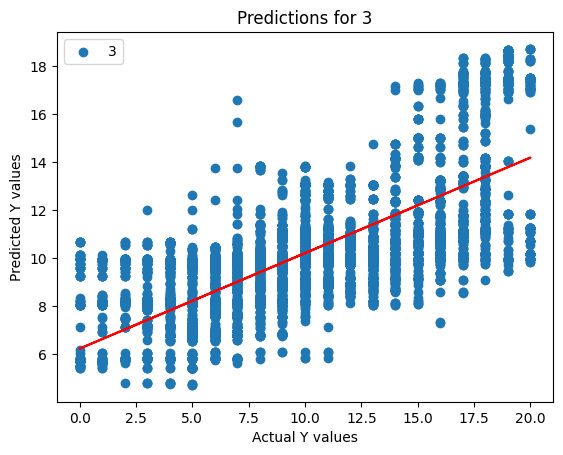

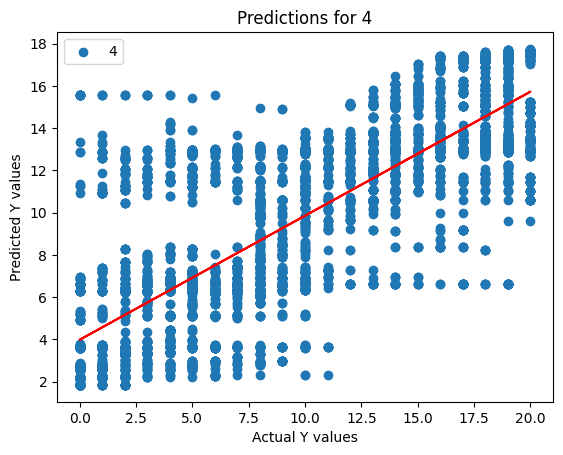

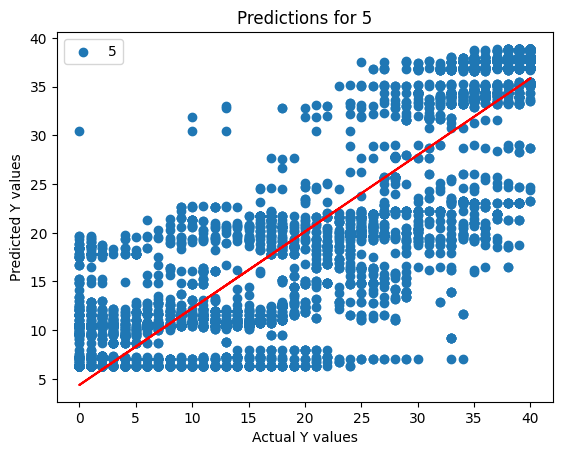

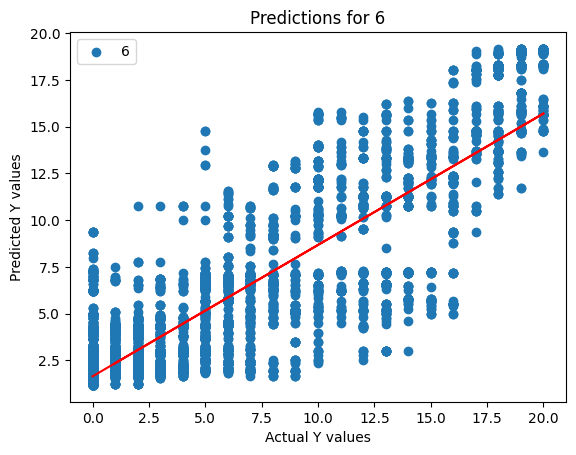

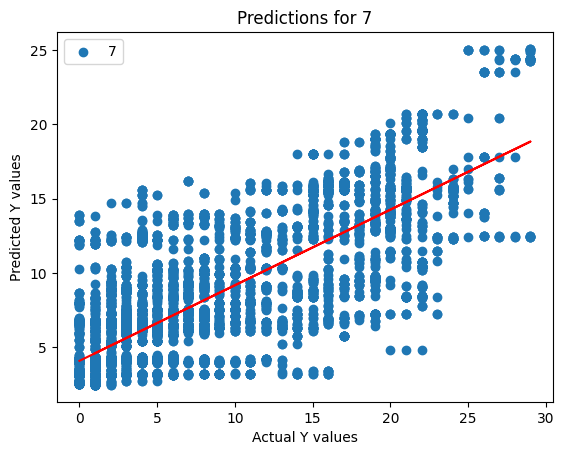

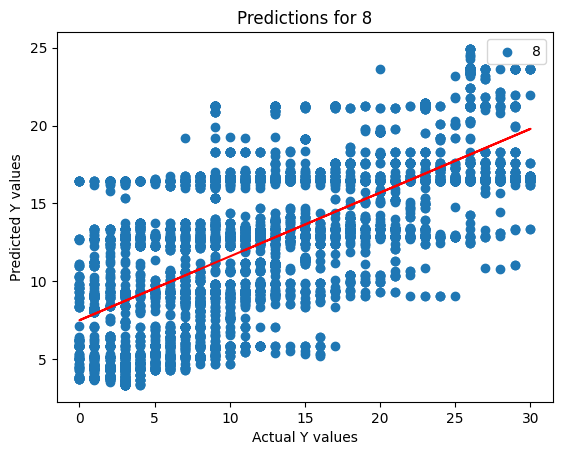

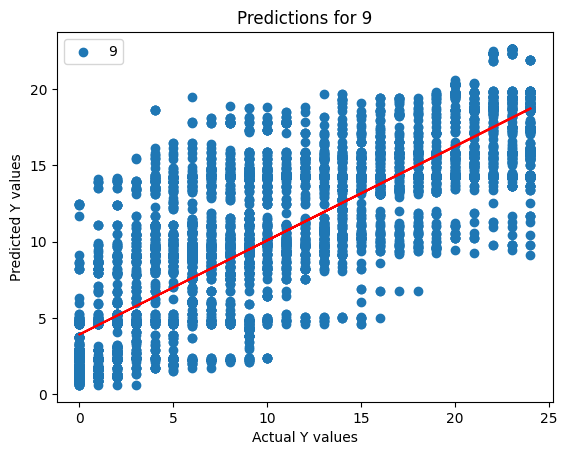

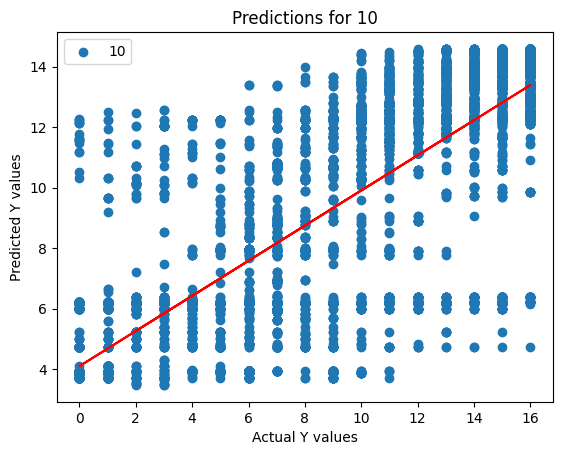

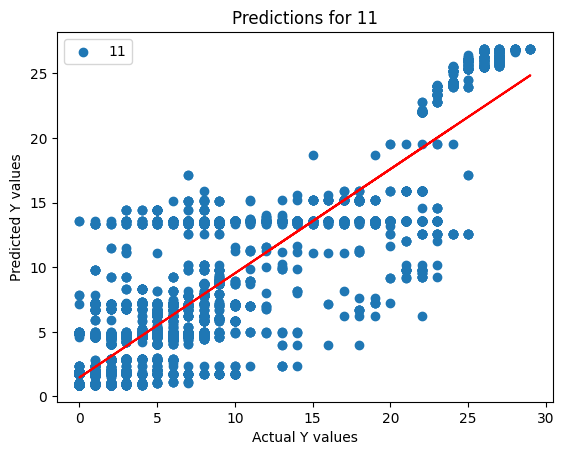

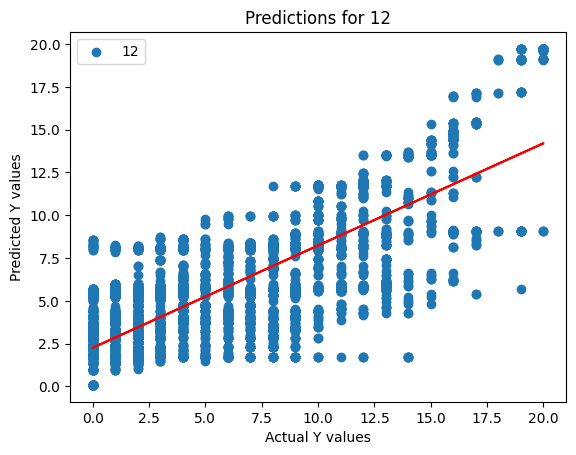

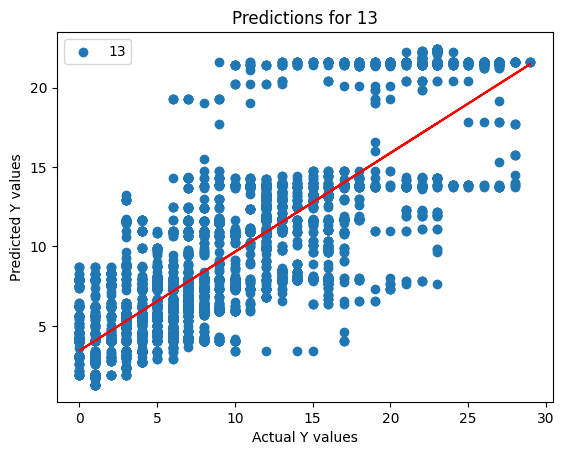

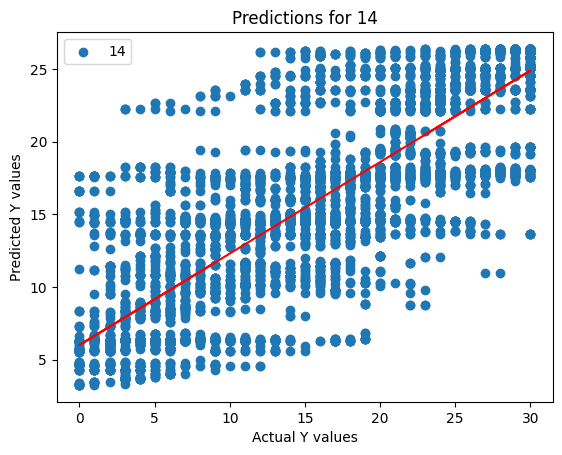

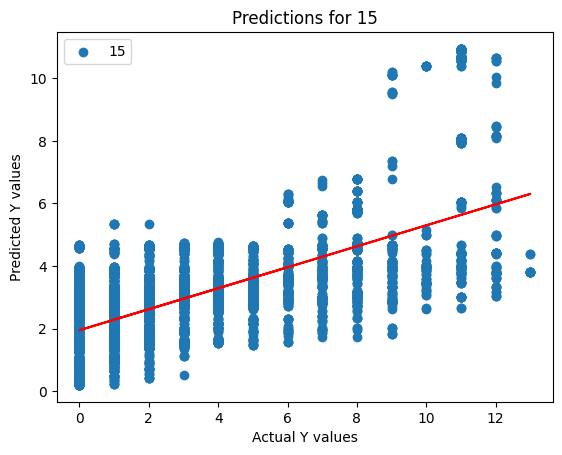

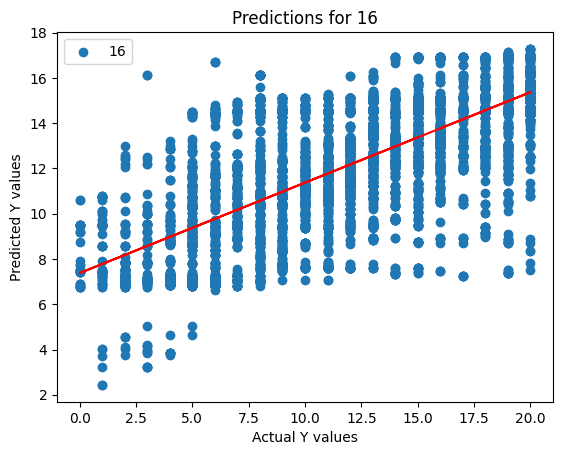

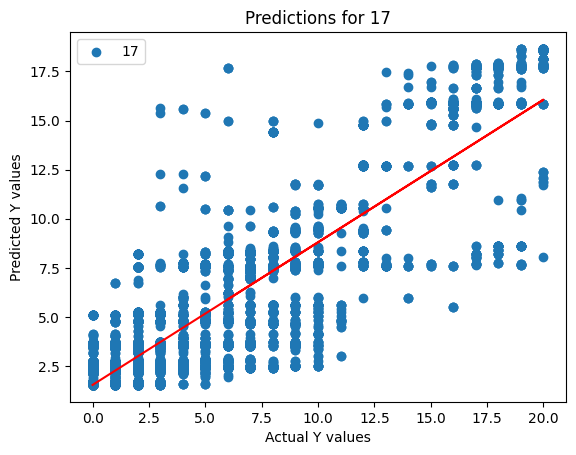

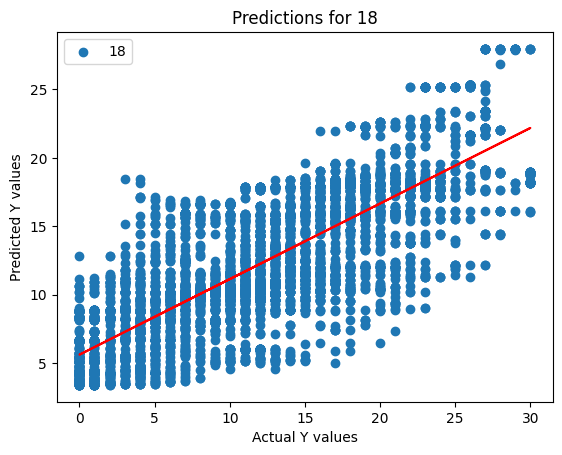

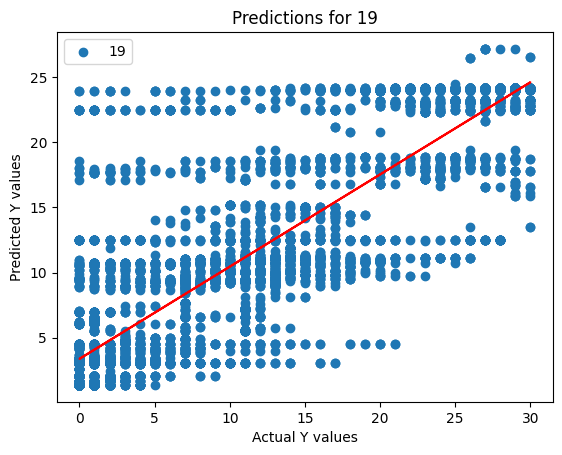

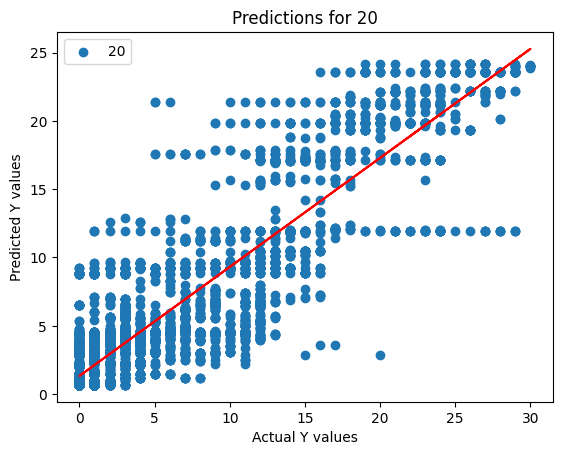

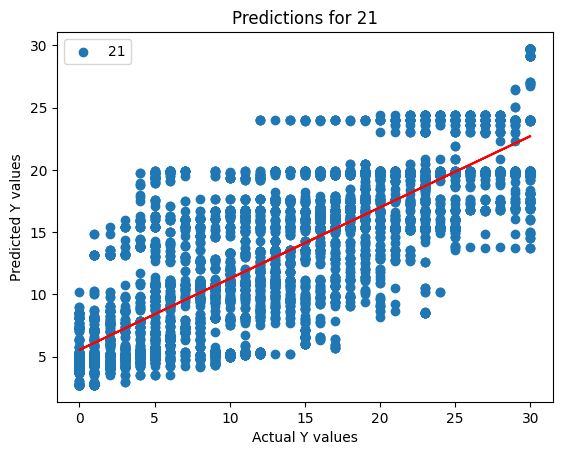

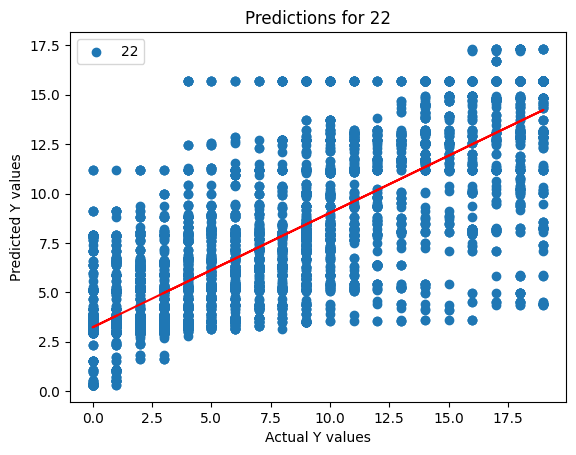

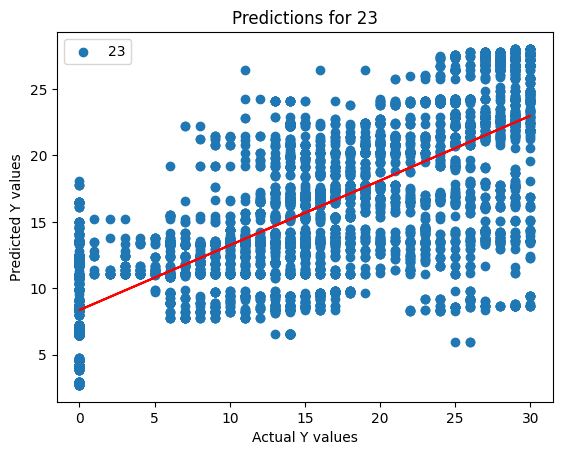

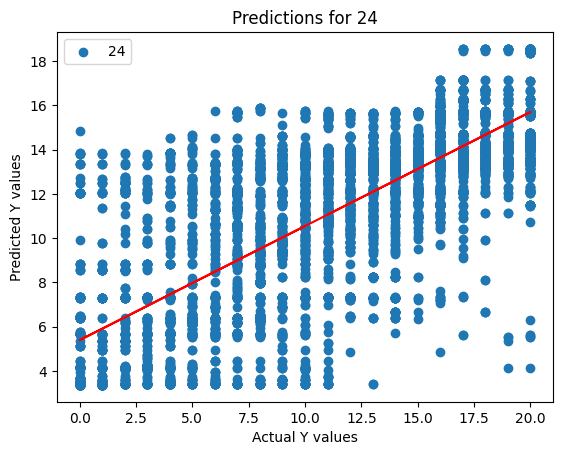

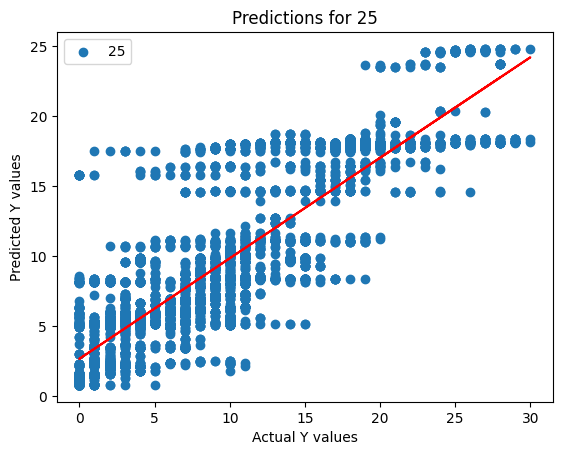

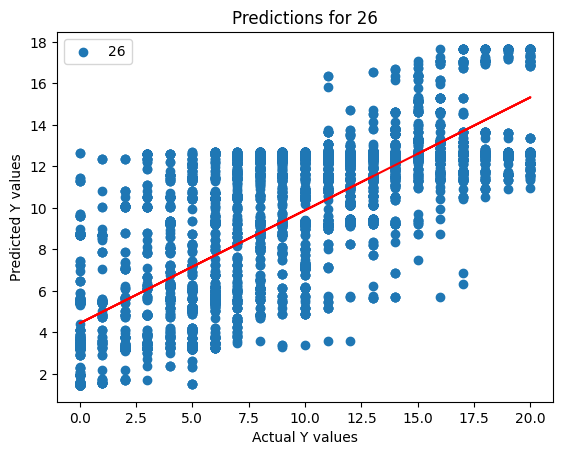

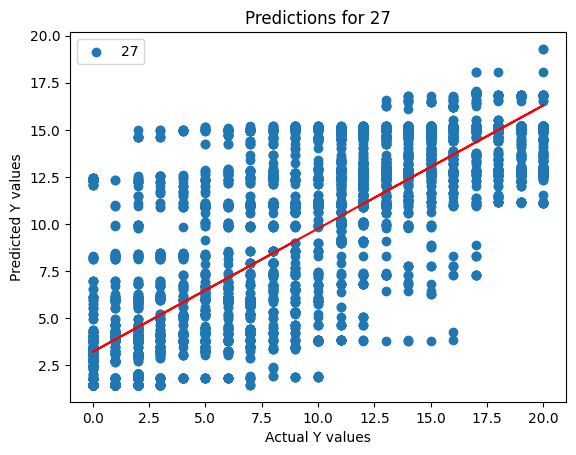

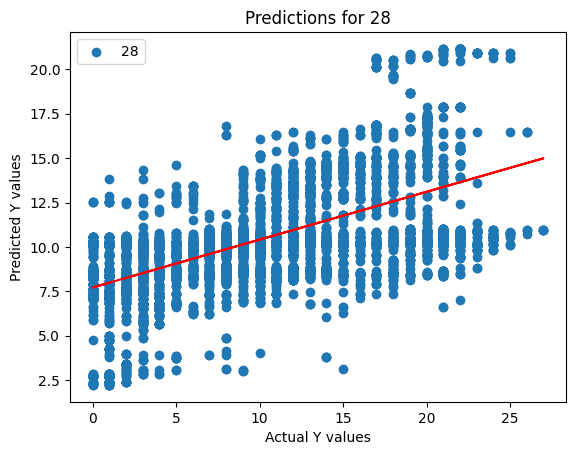

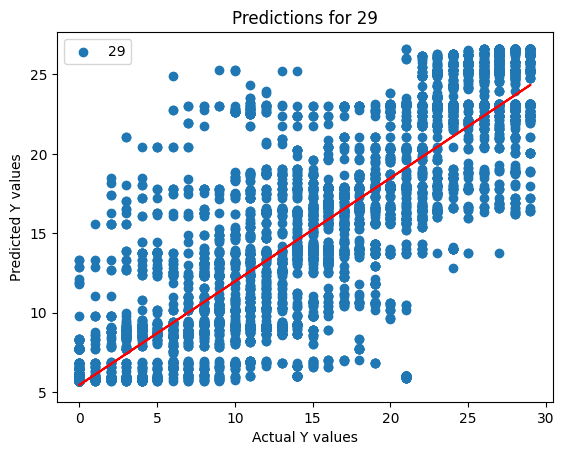

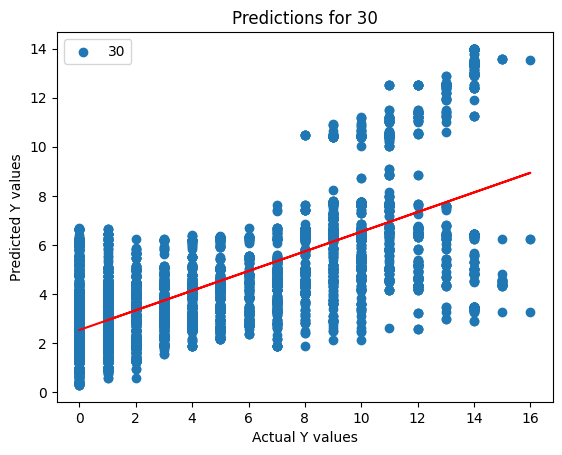

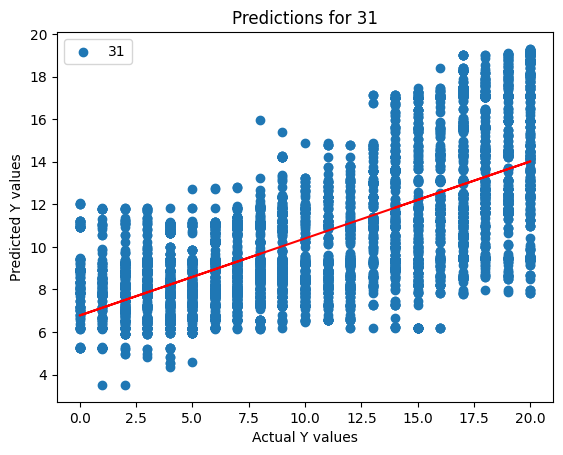

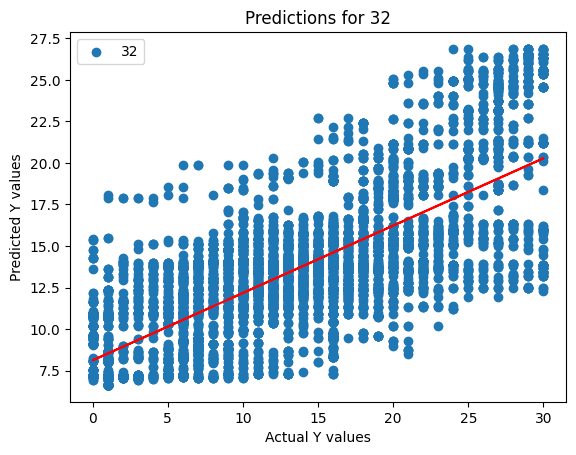

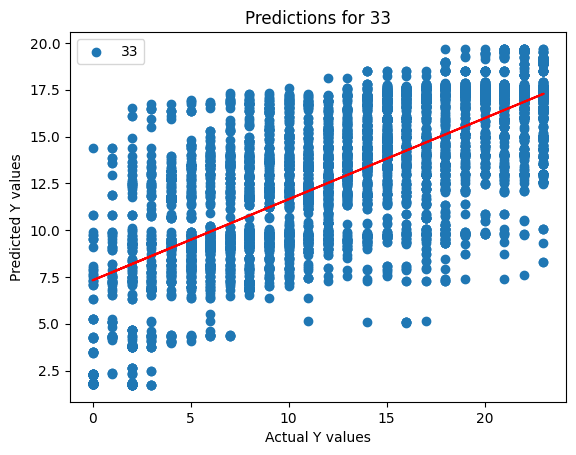

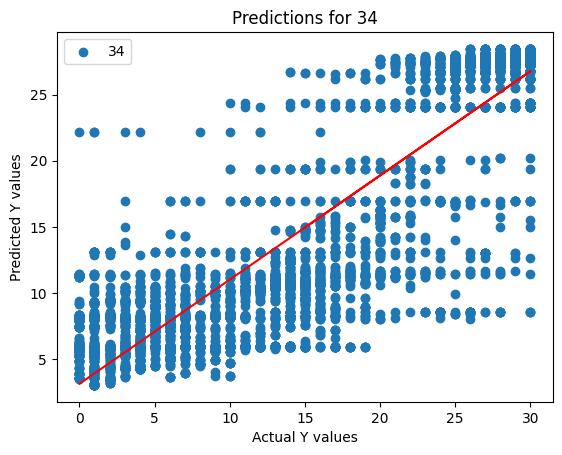

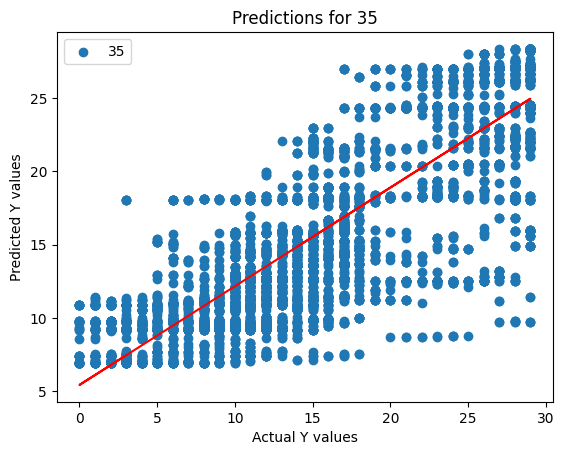

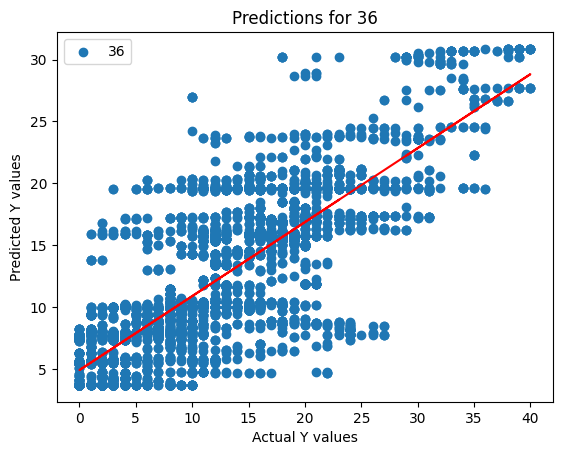

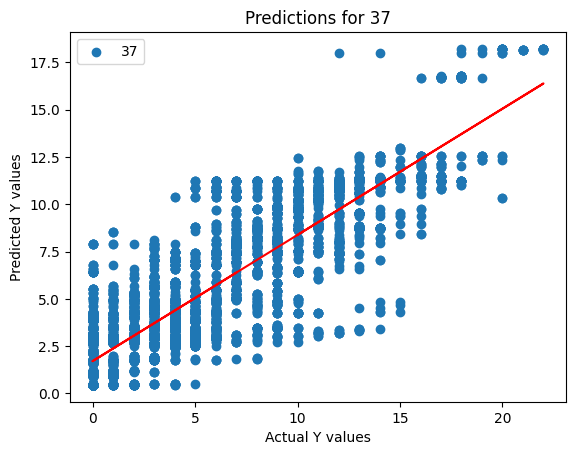

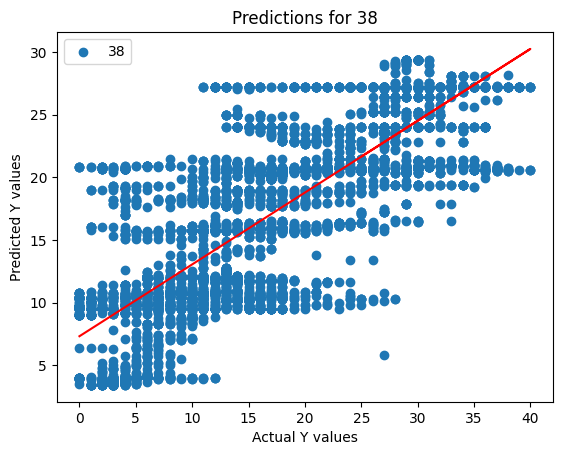

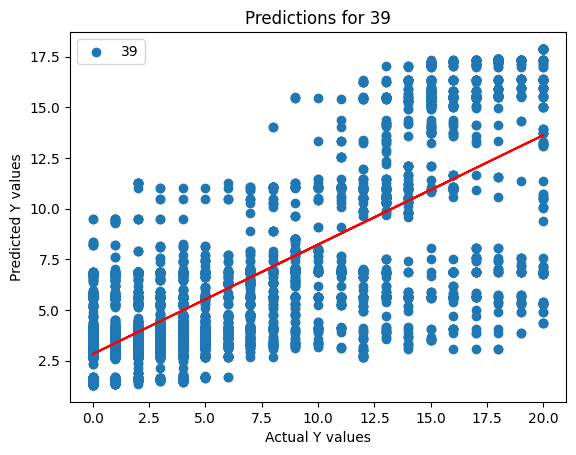

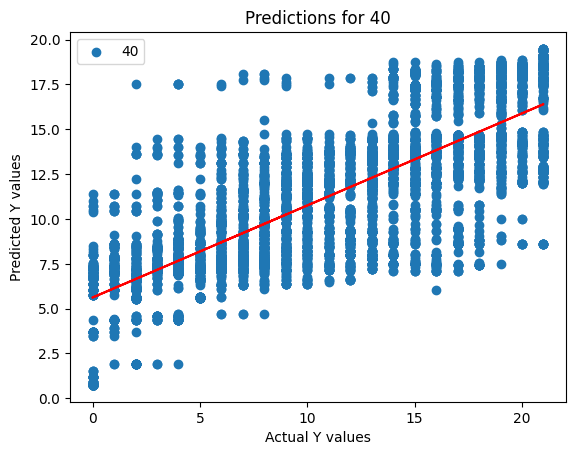

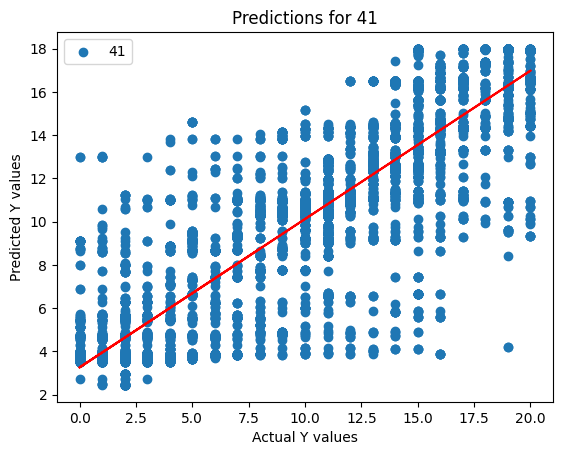

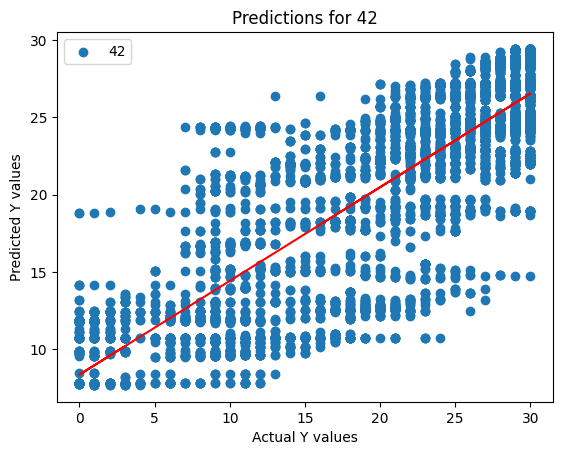

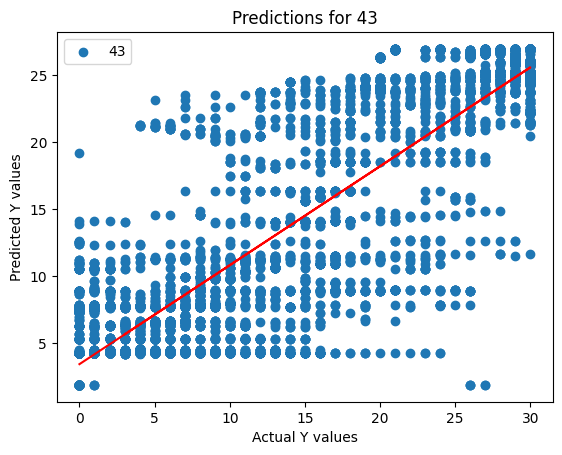

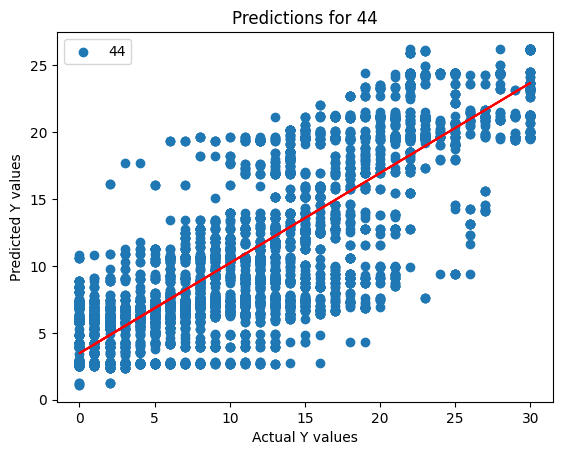

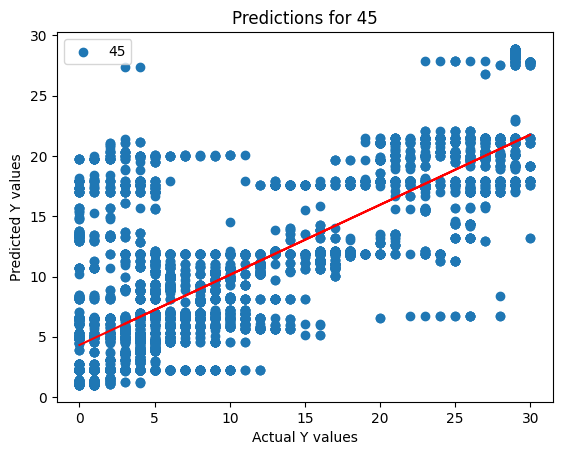

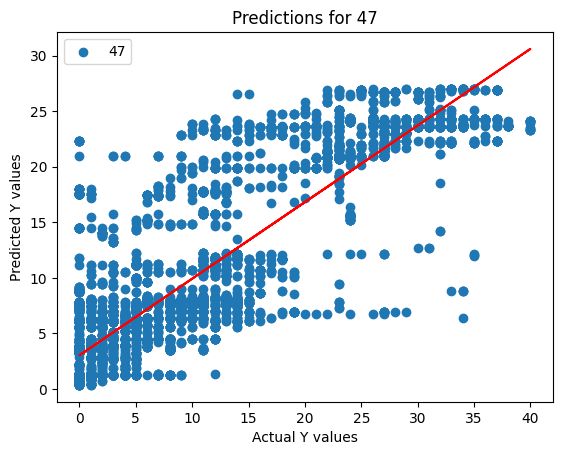

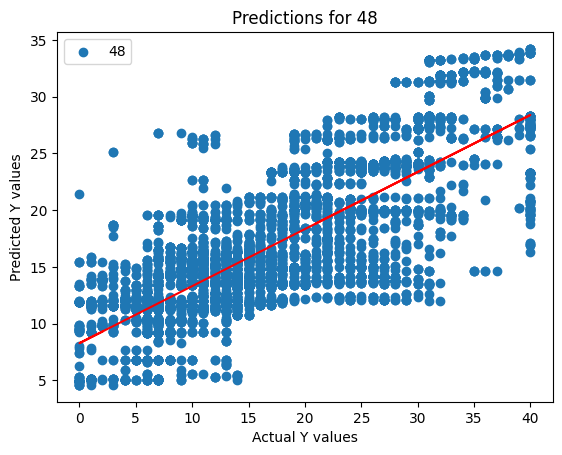

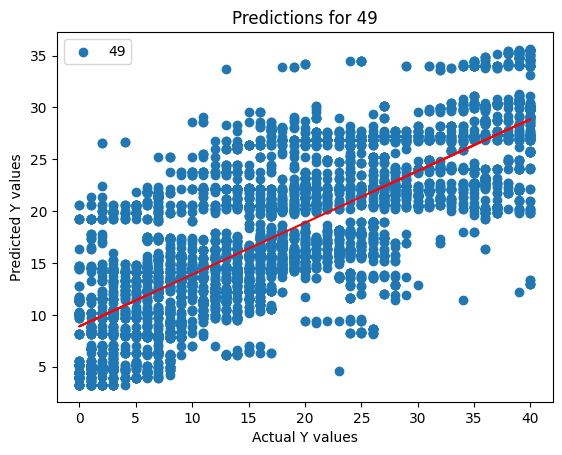

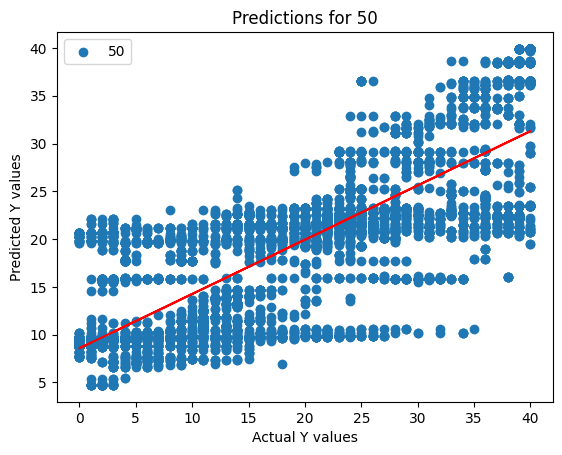

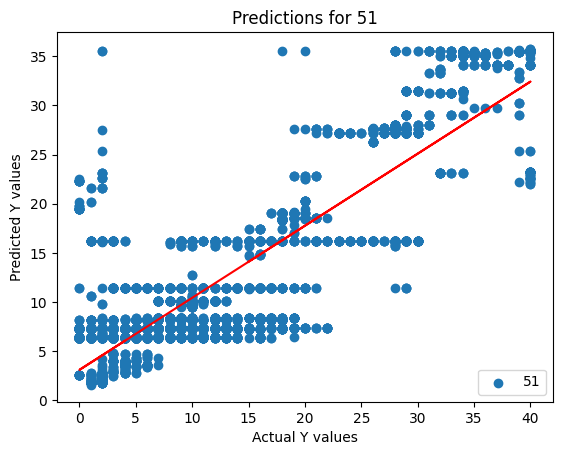

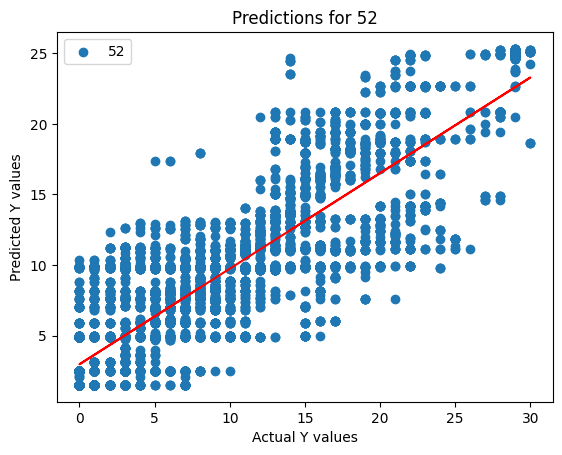

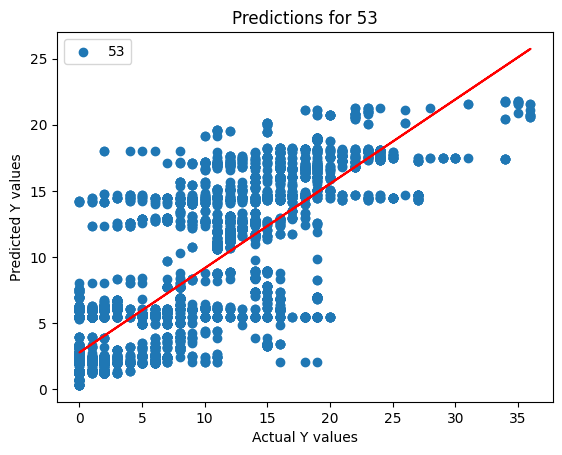

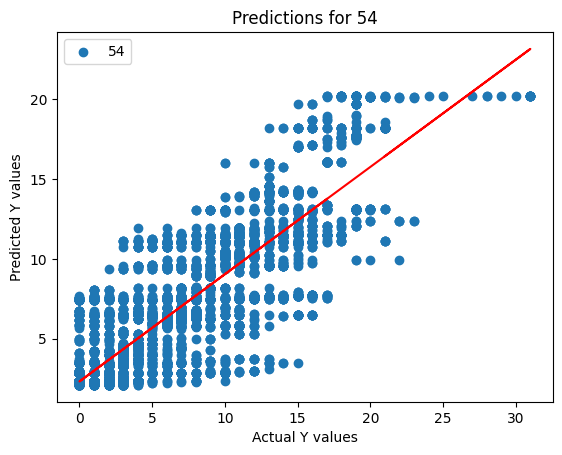

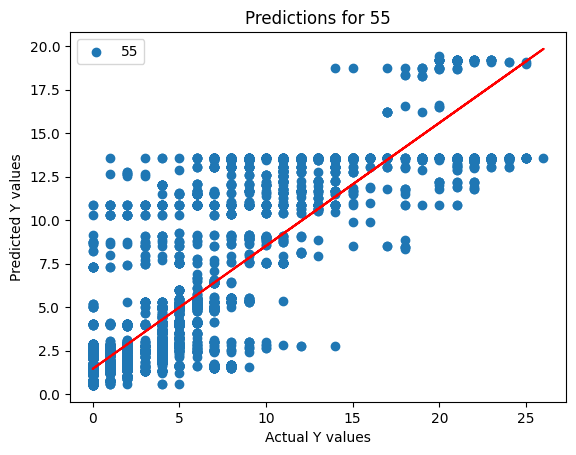

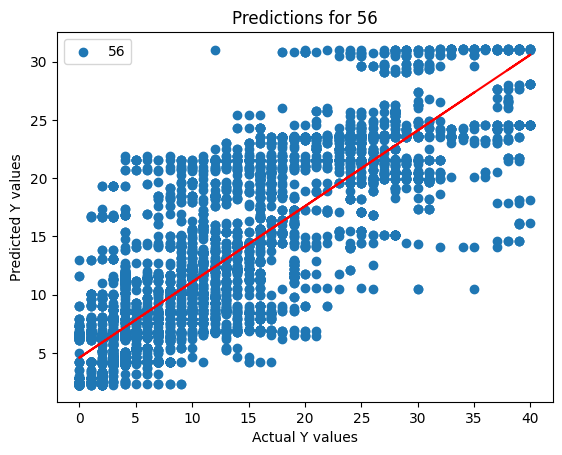

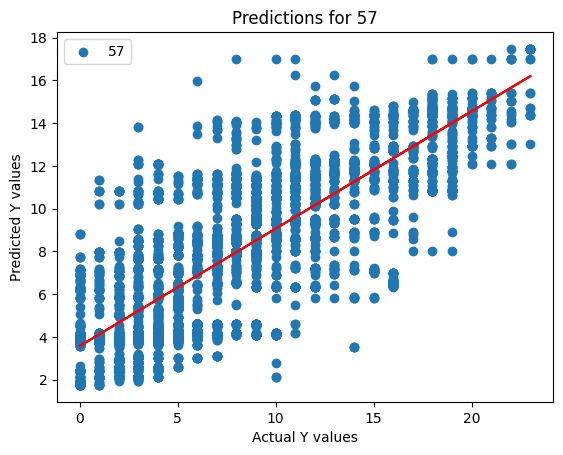

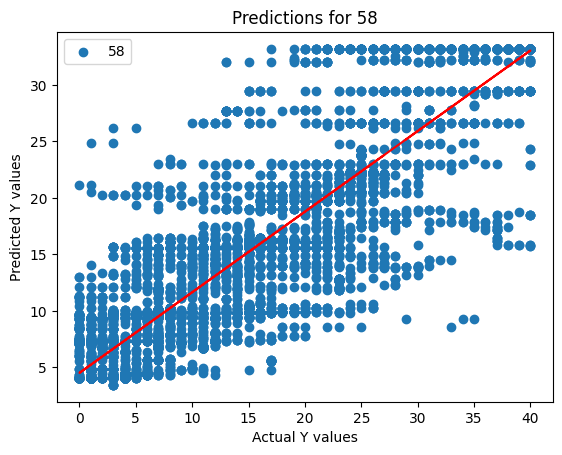

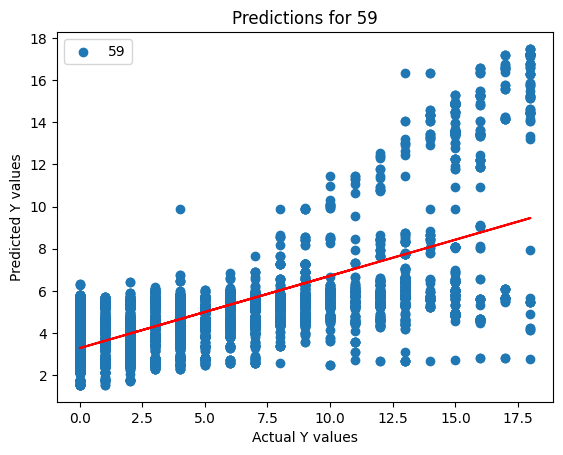

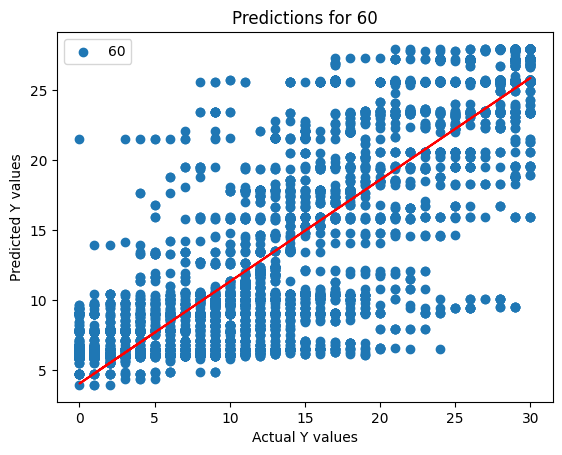

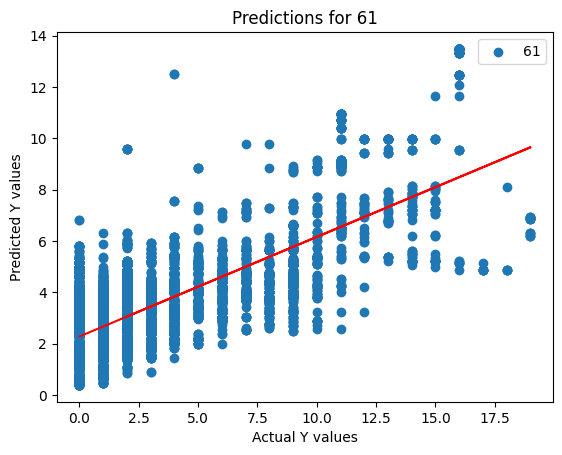

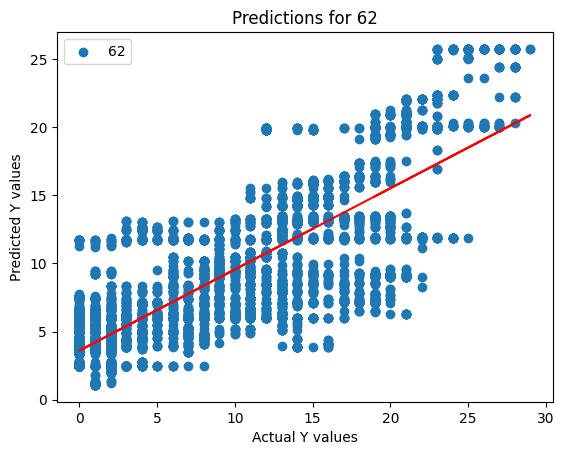

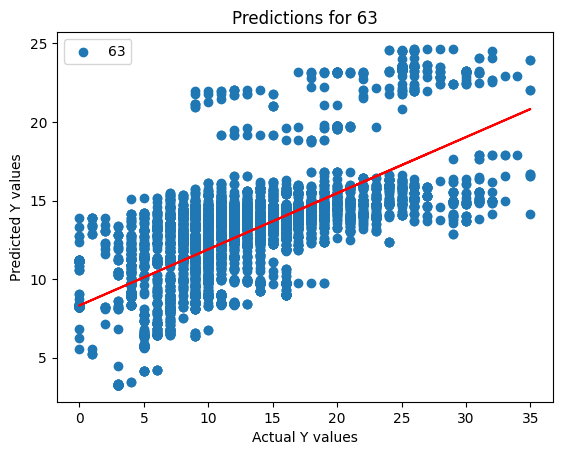

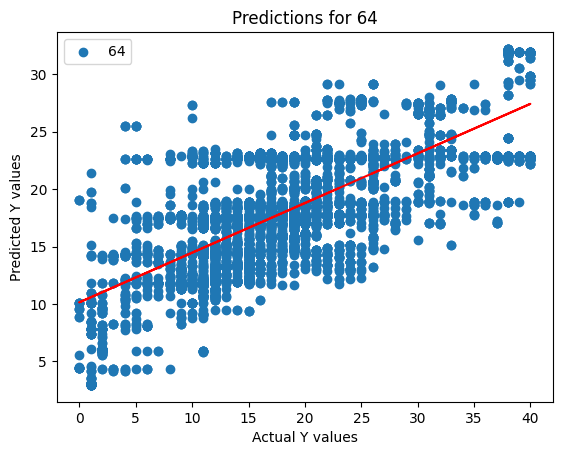

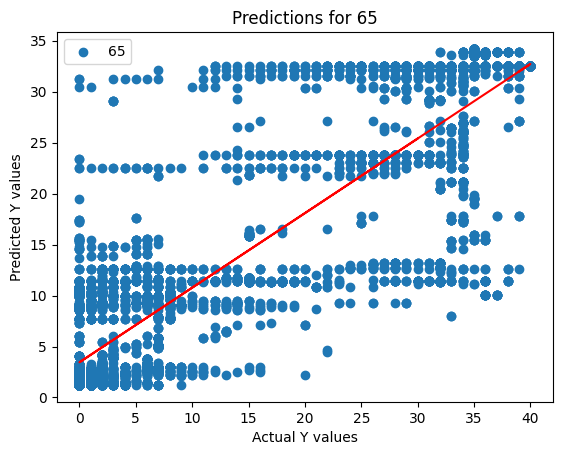

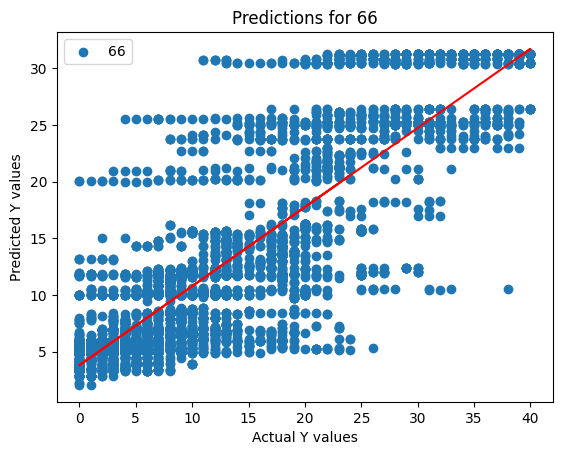

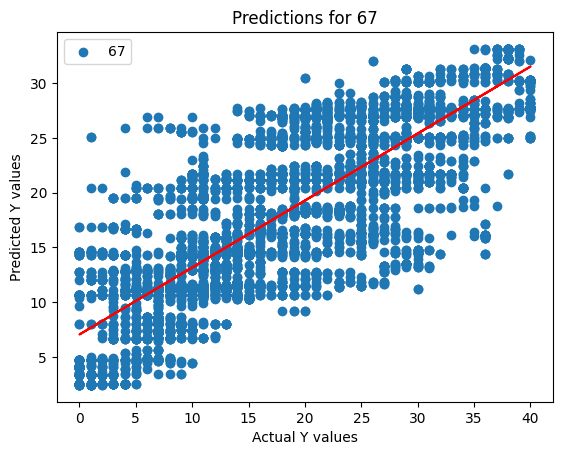

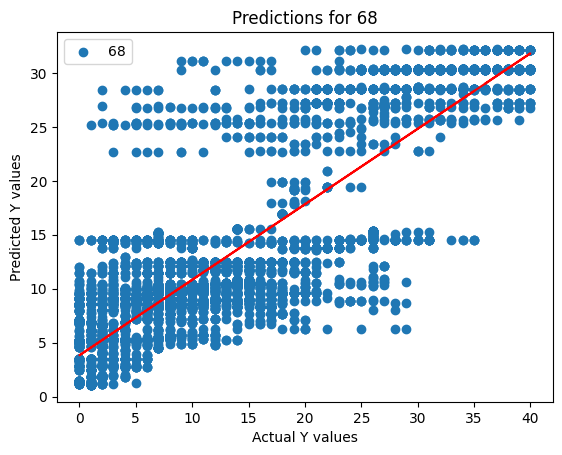

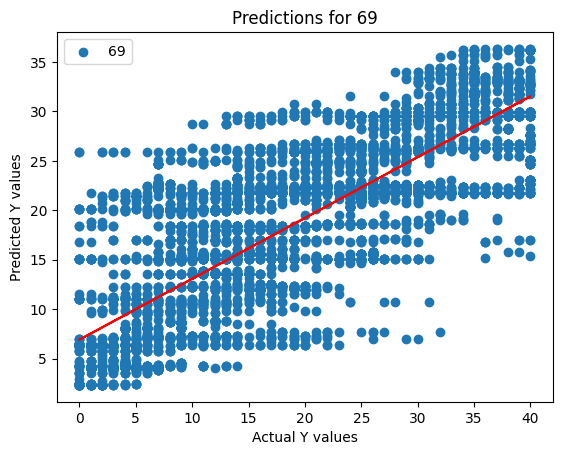

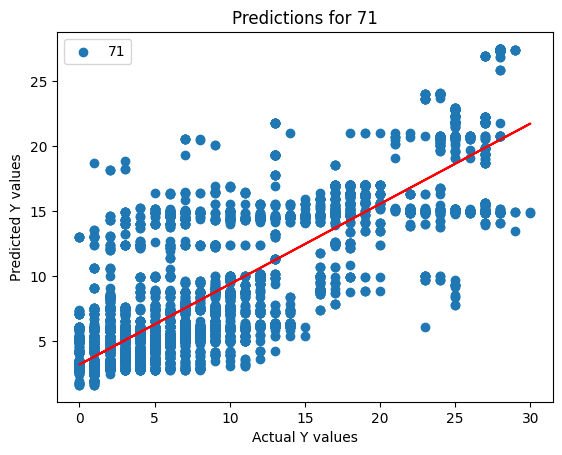

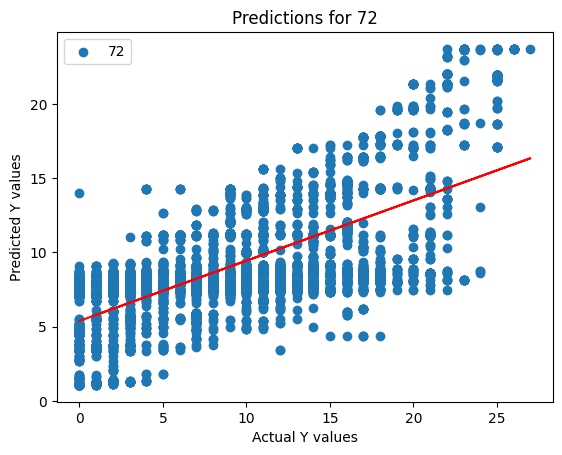

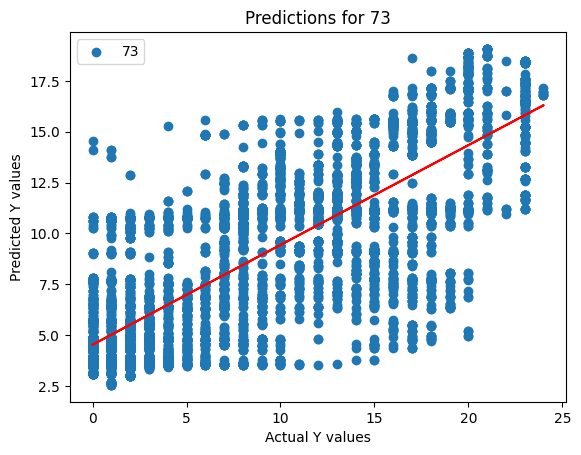

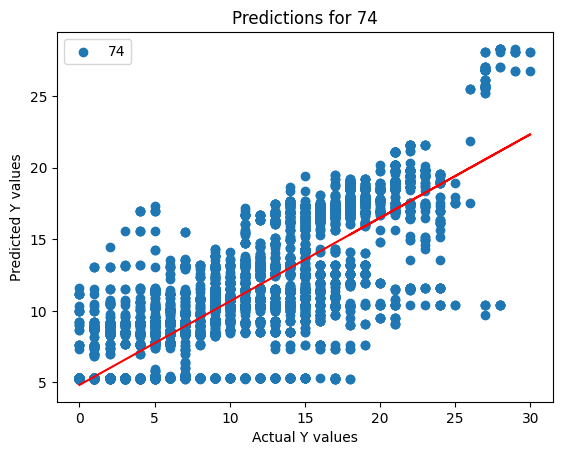

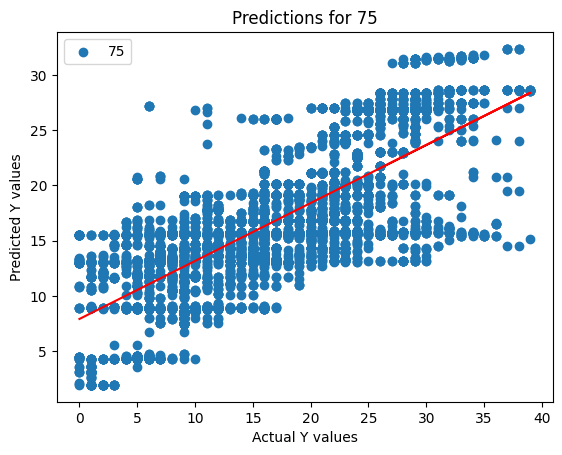

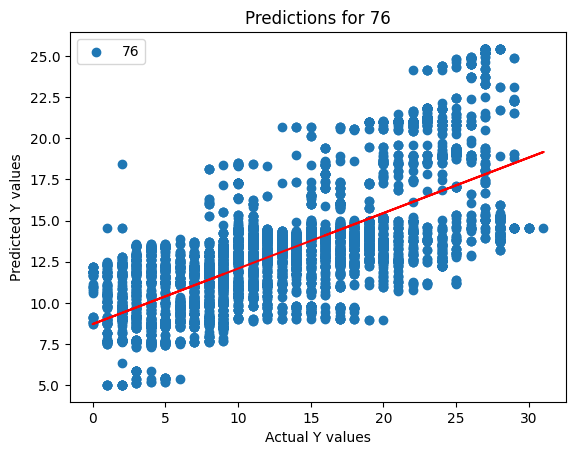

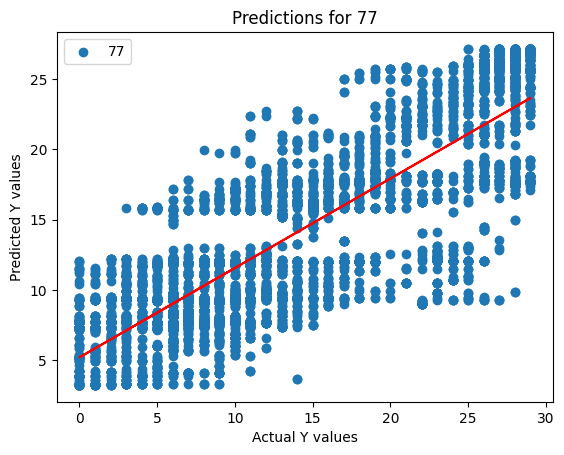

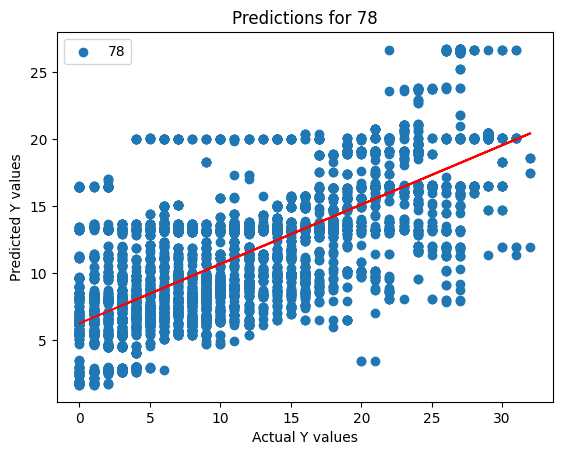

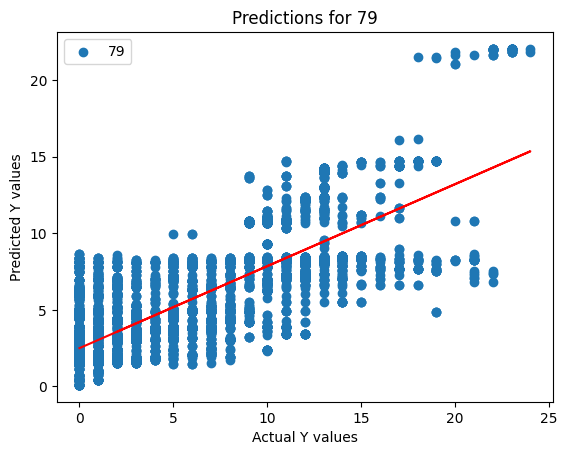

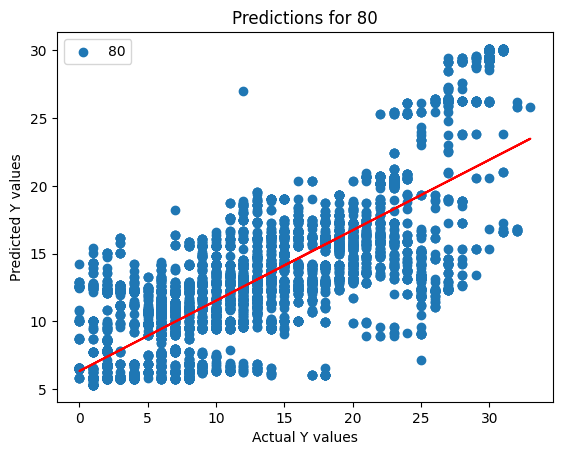

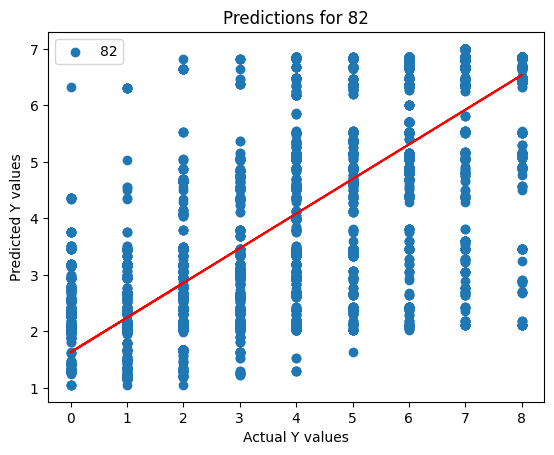

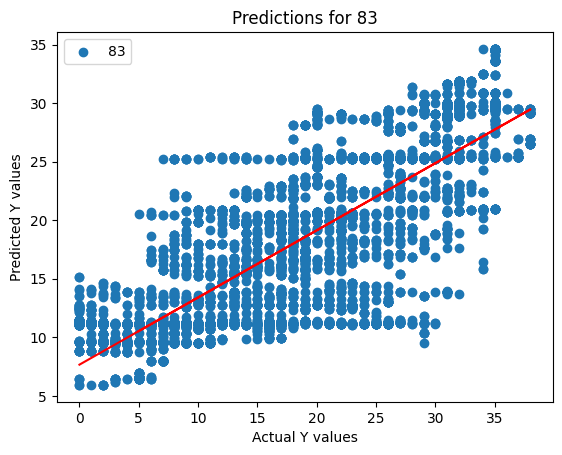

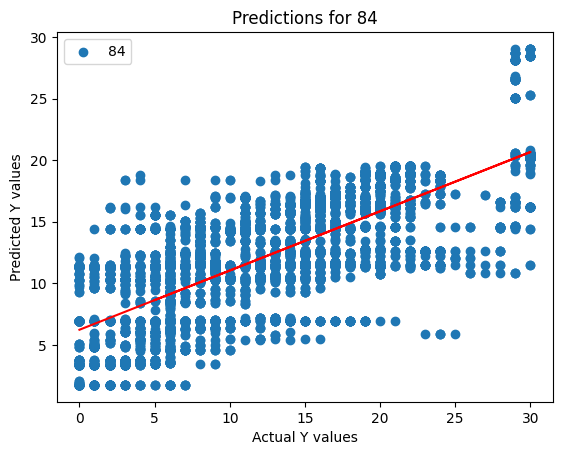

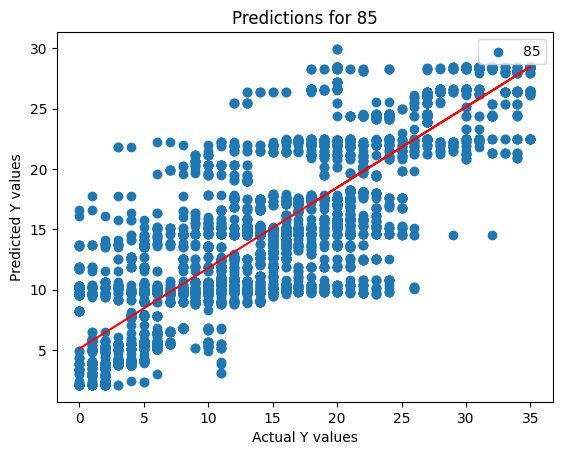

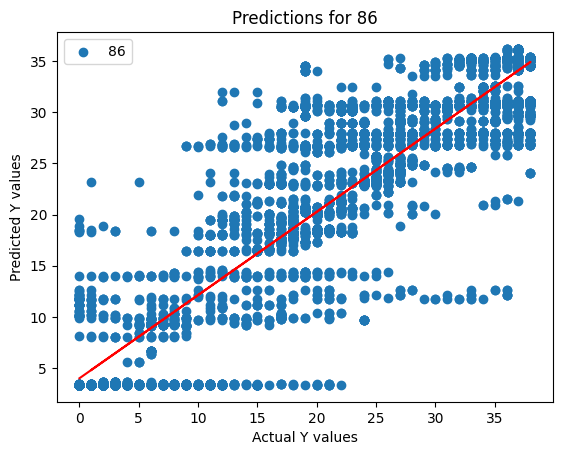

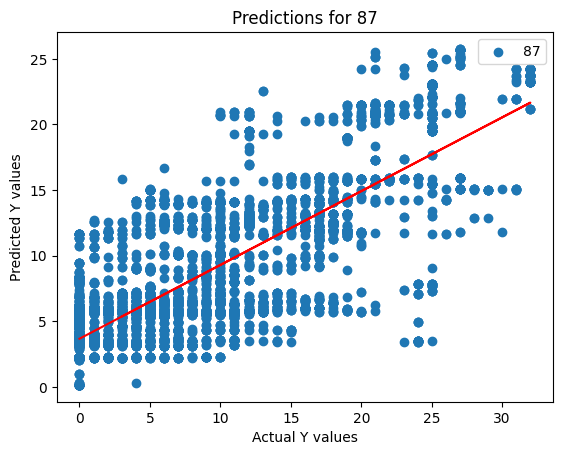

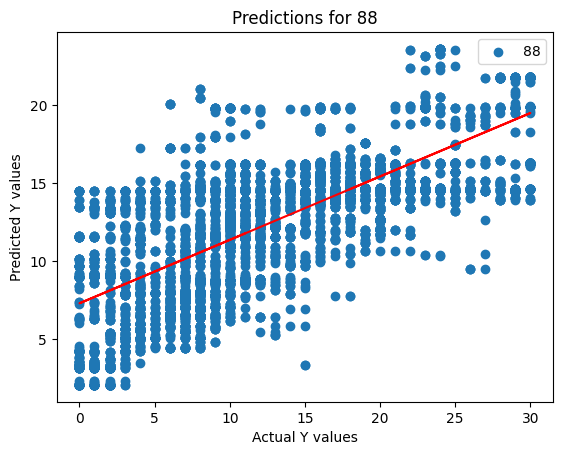

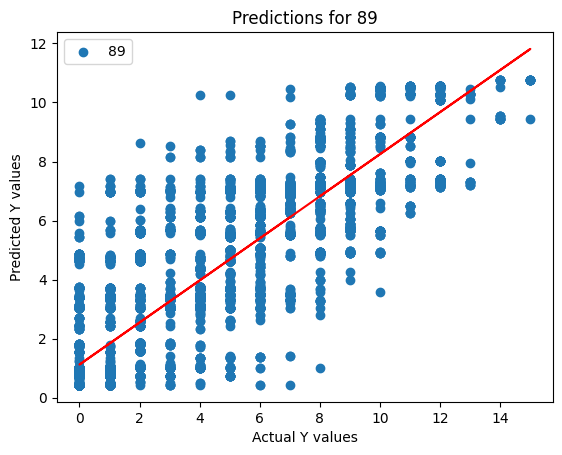

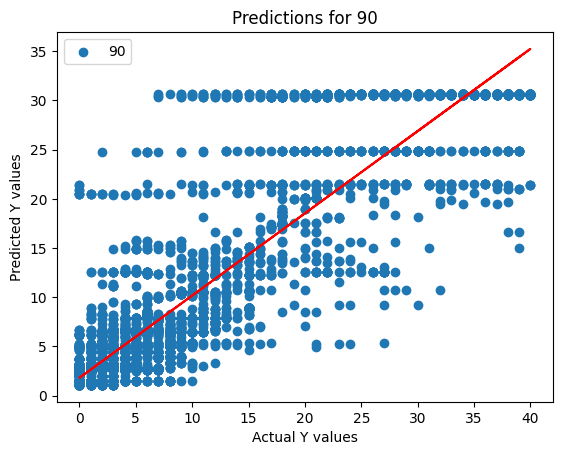

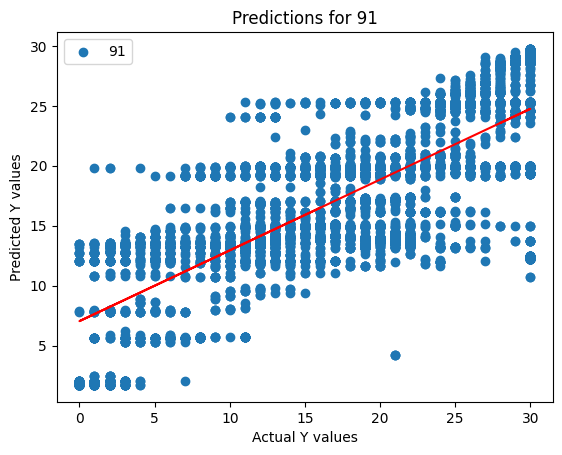

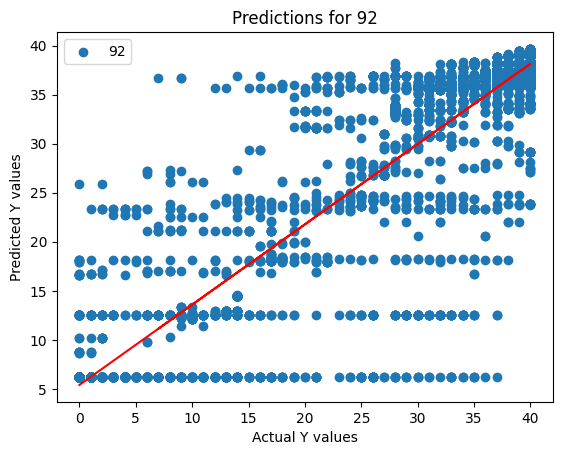

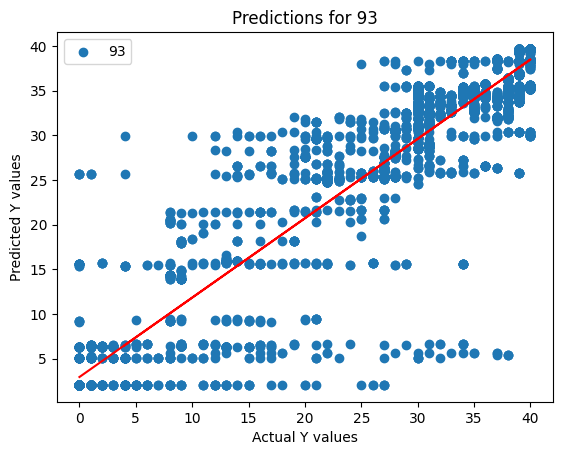

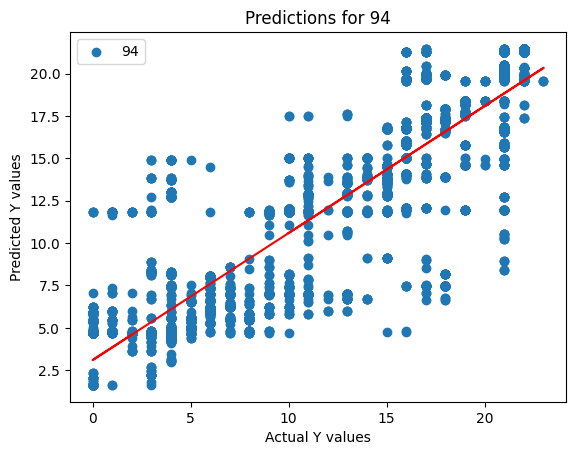

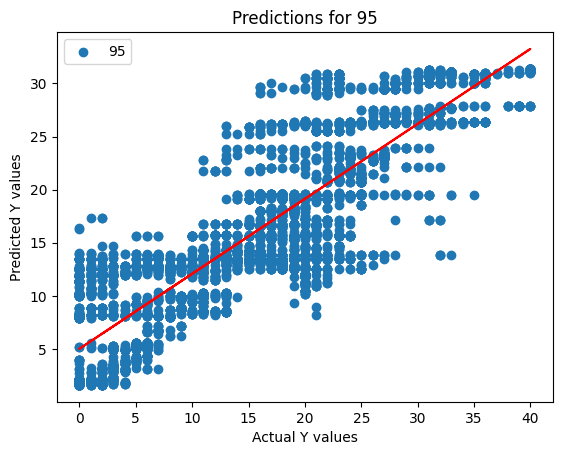

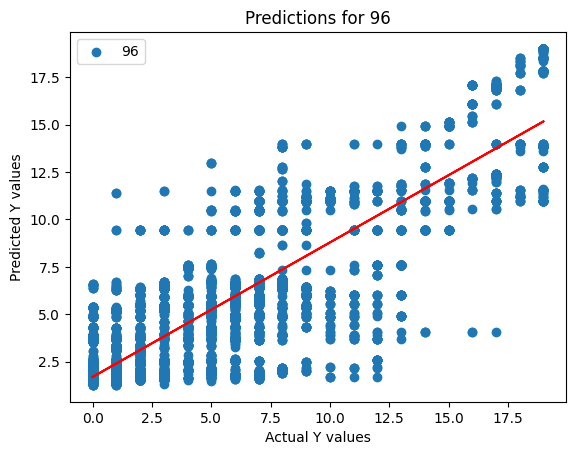

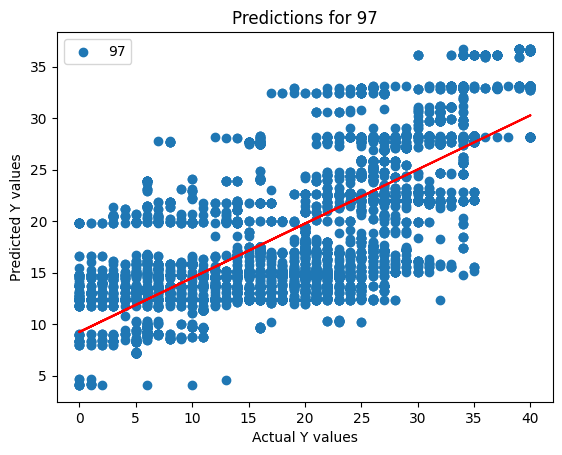

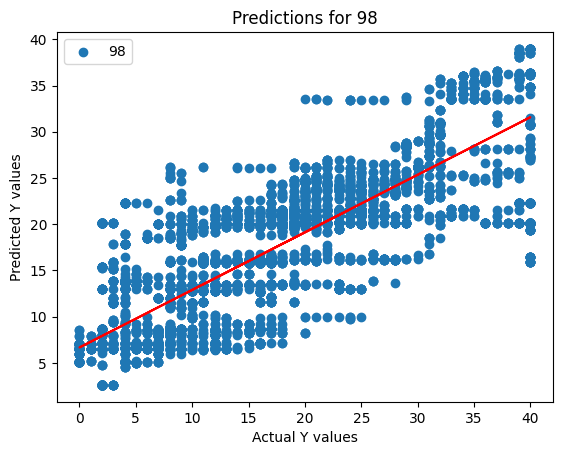

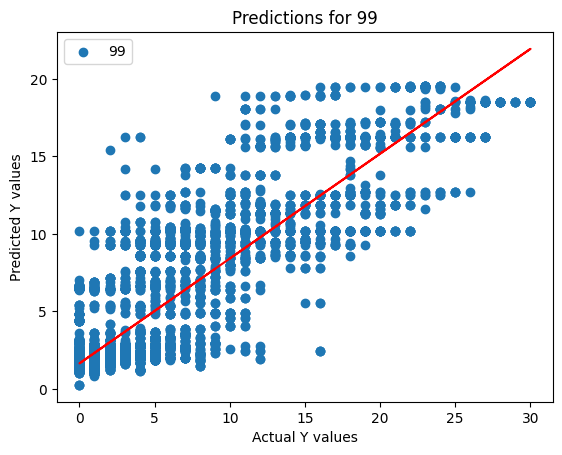

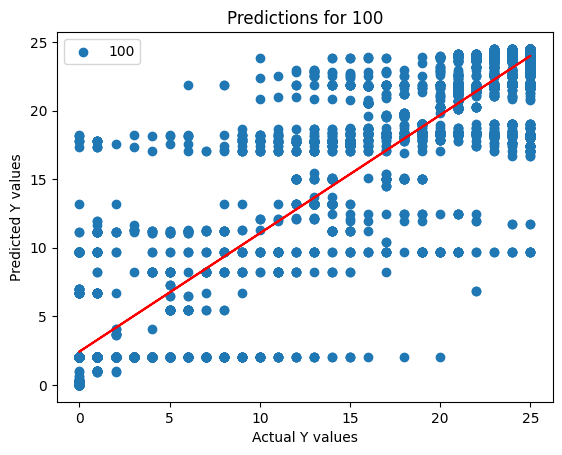

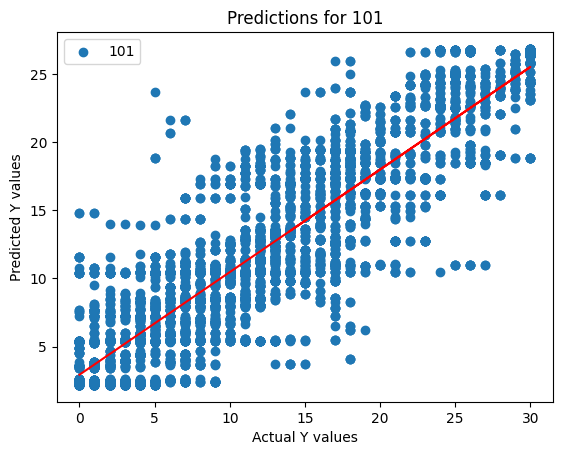

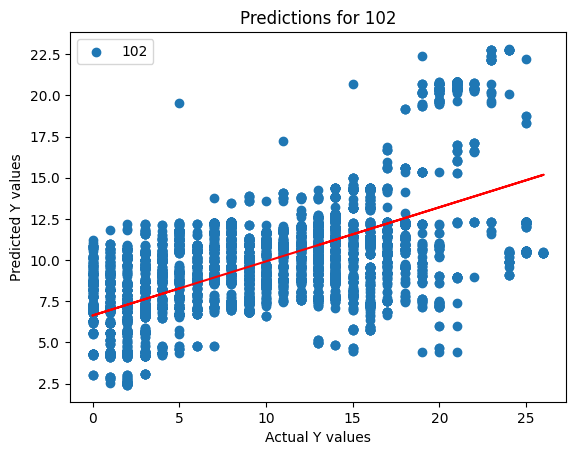

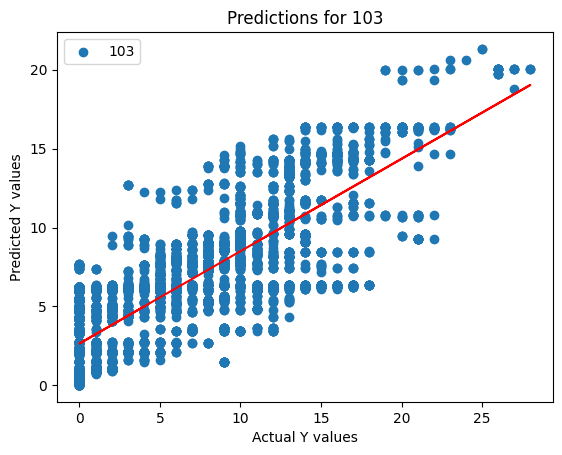

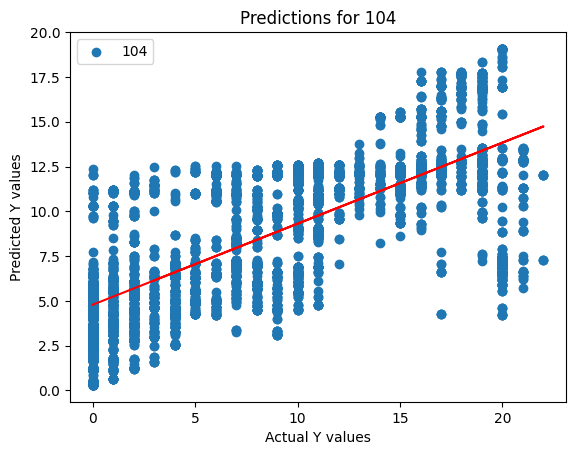

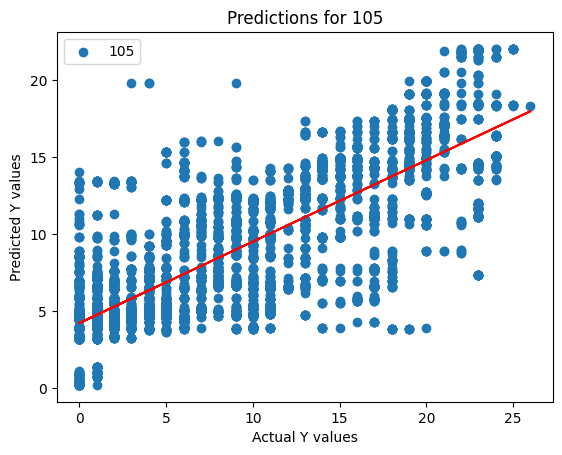

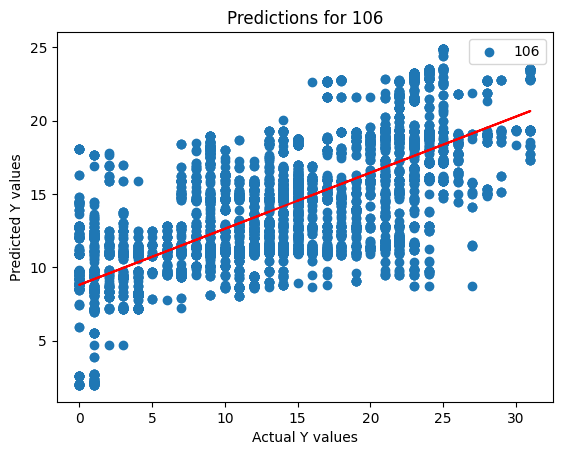

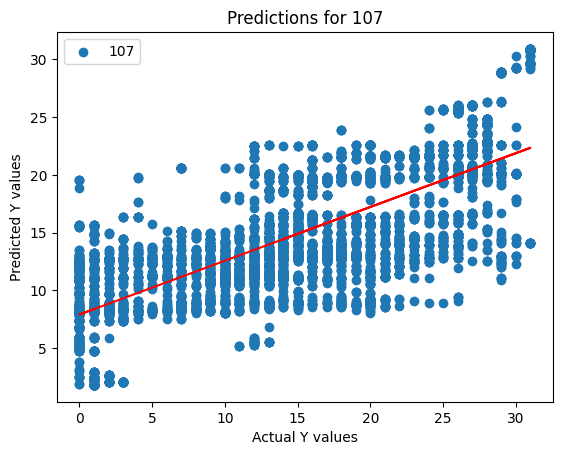

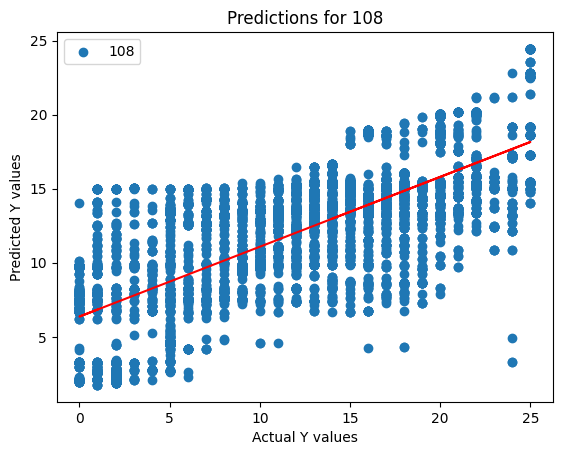

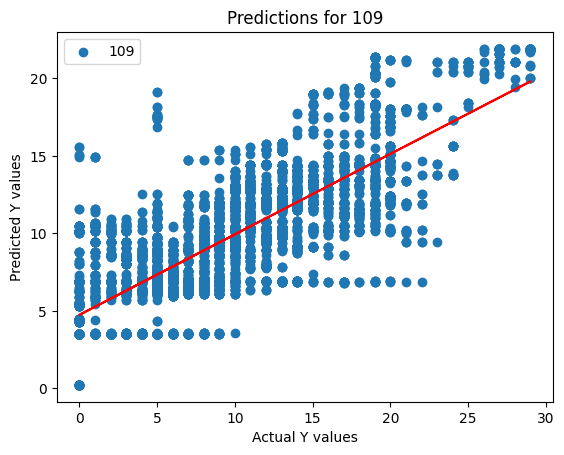

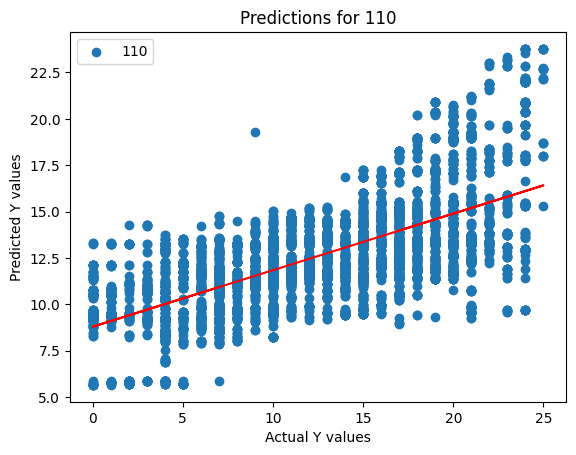

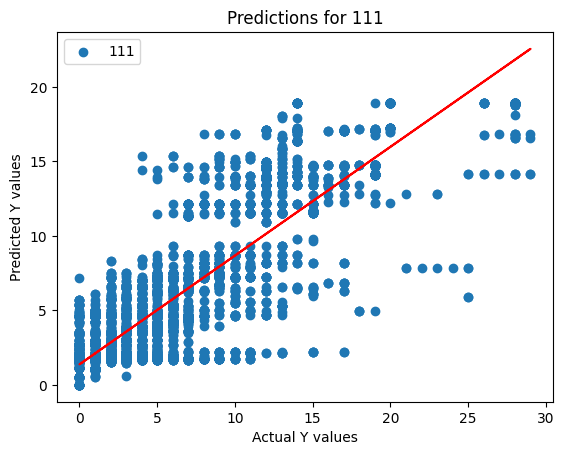

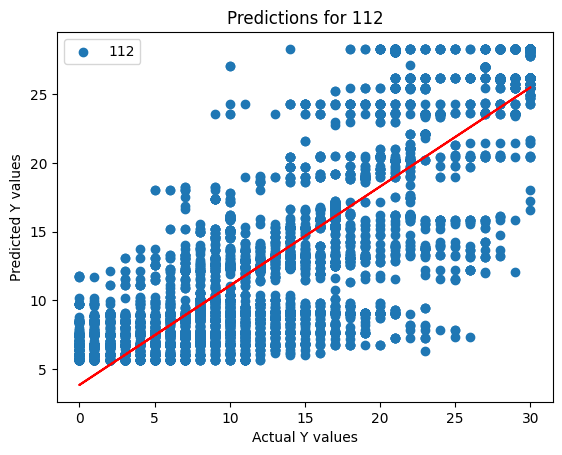

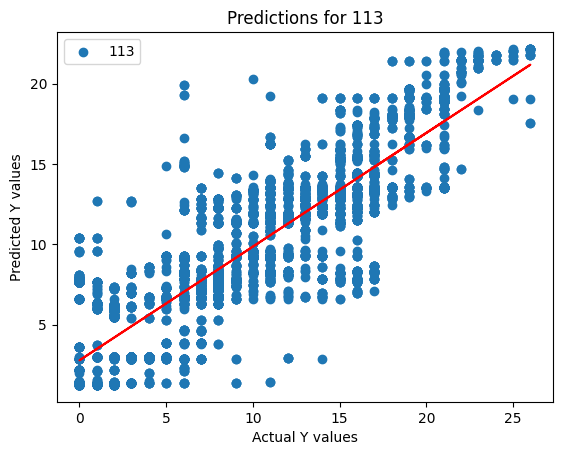

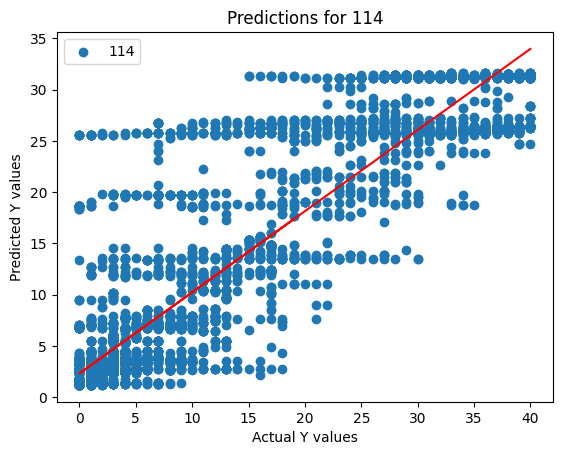

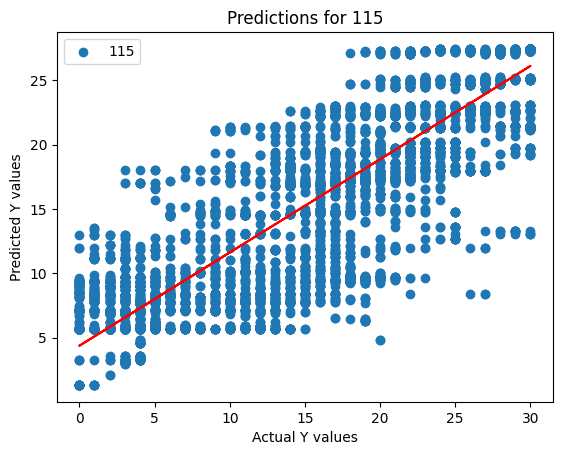

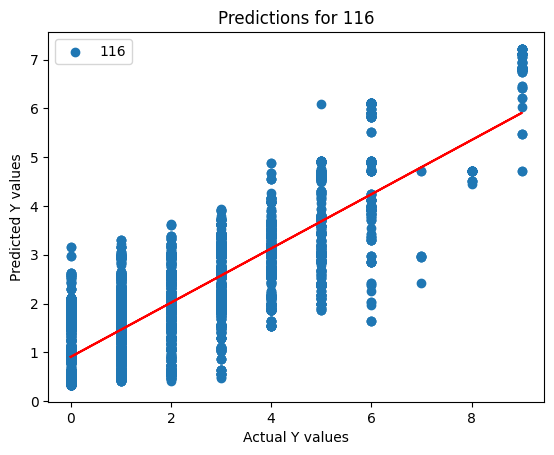

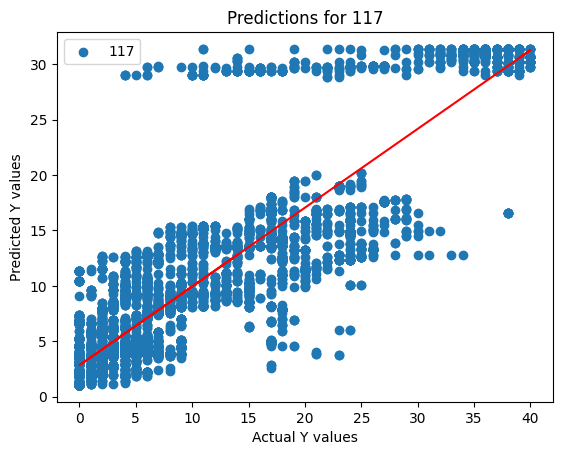

/Users/deanobrien/opt/anaconda3/envs/comp30830/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


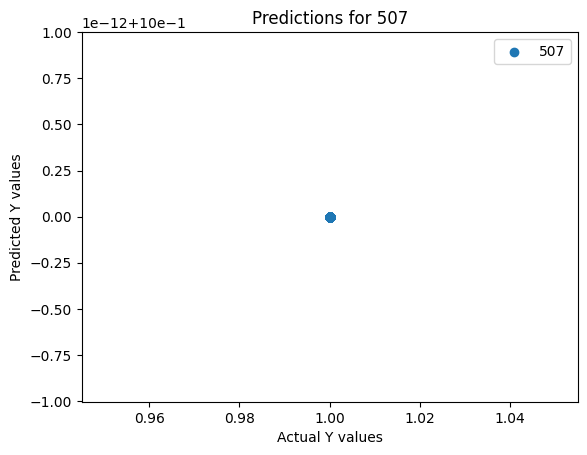

In [18]:
import matplotlib.pyplot as plt

for model_name, model in models.items():
    fig, ax = plt.subplots()
    ax.set_title(f"Predictions for {model_name}")
    for station_num, station_df in stations:
        if station_num == model_name:
            x = station_df.drop("available_bikes", axis=1)
            prediction = model.predict(x)
            y_actual = station_df["available_bikes"].values # extract actual y values
            ax.scatter(y_actual, prediction, label=station_num) # plot actual vs predicted with different marker
            z = np.polyfit(y_actual, prediction, 1) 
            p = np.poly1d(z)
            ax.plot(y_actual, p(y_actual), "r") 

    ax.set_xlabel("Actual Y values")
    ax.set_ylabel("Predicted Y values")
    ax.legend()
    plt.show()

            


## Saving models to pickle file

In [19]:
# import pickle

# with open("models.pkl", "wb") as f:
#     pickle.dump(models, f)